In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/train"
val_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test"
test_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 8912
Number of images in validation dataset: 1103
Number of images in test dataset: 1103


In [5]:
num_classes = len(train_dataset.classes)

In [7]:
import torch
import torch.nn as nn
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Average pooling
        avg_out = self.avg_pool(x).view(b, c)
        avg_out = self.fc(avg_out).view(b, c, 1, 1)
        
        # Max pooling
        max_out = self.max_pool(x).view(b, c)
        max_out = self.fc(max_out).view(b, c, 1, 1)
        
        # Combine features
        out = avg_out + max_out
        return x * out

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        
        # Load DenseNet-201 pretrained model
        base_model = models.densenet201(pretrained=True)
        
        # Extract features and remove the classifier
        self.features = nn.Sequential(*list(base_model.features.children()))
        
        # Get the number of output channels from the base model
        num_features = base_model.features[-1].num_features
        
        # Channel attention module
        self.channel_attention = ChannelAttention(num_features)
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        # Extract features
        x = self.features(x)
        
        # Apply channel attention
        x = self.channel_attention(x)
        
        # Classify
        x = self.classifier(x)
        
        return x

In [8]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [9]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [11]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [15]:
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):
    
    ensemble_models = []
    snapshot_epochs = [1, 2, 3]  # Adjusted snapshot epochs
    best_snapshot_weights = None

    model = CustomModel(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)       
    
    criterion =  CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)
    
    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 3
    
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)
            
        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/120, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/120"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)
        
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}")


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())


        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)
        
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            # Evaluate using the best model up to this snapshot
            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []
            test_probs = []

            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    test_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)
            
            test_accuracy = test_correct / test_total
            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))
            
            # Inside the loop where you evaluate the model on the test set
            conf_matrix = confusion_matrix(test_labels, test_preds)
            
            # Calculate percentages
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            # Plot confusion matrix
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            # Plot accuracy and loss curves
            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')
            
            # Plot learning rate curve
            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()
            
        scheduler.step()

    return ensemble_models

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using 2 GPUs!
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120:   0%|          | 0/70 [00:00<?, ?it/s]

Train Loss: 0.4263, Train Accuracy: 0.7286, Train Precision: 0.7269, Train Recall: 0.7286, Train F1 Score: 0.7272


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Loss: 0.2158, Validation Accuracy: 0.9066, Validation Precision: 0.9015, Validation Recall: 0.9066, Validation F1 Score: 0.9017
Best model updated based on validation accuracy
Snapshot 0 saved


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Test Loss: 0.2158, Test Accuracy: 0.9066, Test Precision: 0.9015, Test Recall: 0.9066, Test F1 Score: 0.9017
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        30
           1       0.85      0.66      0.74        35
           2       0.68      0.60      0.64        88
           3       1.00      0.62      0.77         8
           4       0.58      0.65      0.61        46
           5       0.95      0.98      0.96       883
           6       1.00      1.00      1.00        13

    accuracy                           0.91      1103
   macro avg       0.81      0.69      0.74      1103
weighted avg       0.90      0.91      0.90      1103



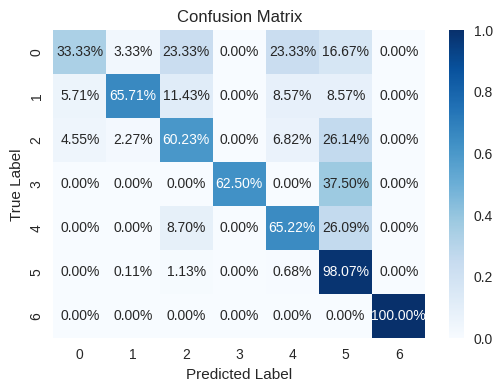

Test Sensitivity: 0.9200, Test Specificity: 0.9091


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


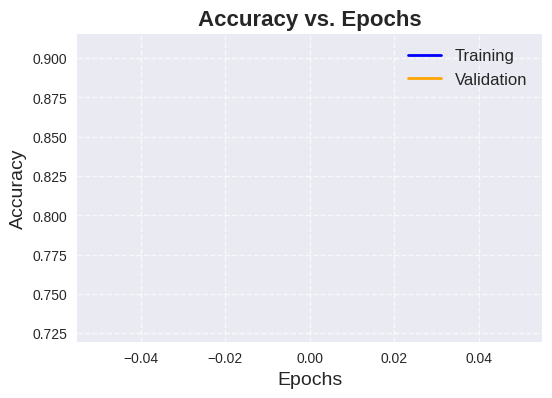

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


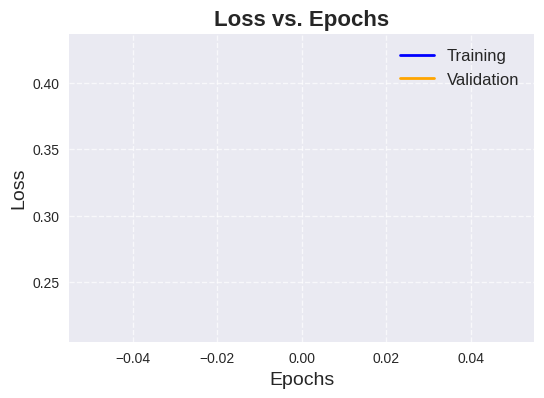

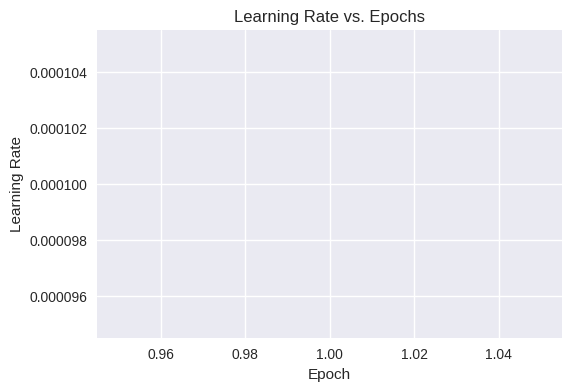

Epoch 2/120, Learning Rate: 0.0001


Epoch 2/120:   0%|          | 0/70 [00:00<?, ?it/s]

Train Loss: 0.1628, Train Accuracy: 0.8846, Train Precision: 0.8806, Train Recall: 0.8846, Train F1 Score: 0.8809


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Loss: 0.1484, Validation Accuracy: 0.9157, Validation Precision: 0.9077, Validation Recall: 0.9157, Validation F1 Score: 0.9097
Best model updated based on validation accuracy
Snapshot 1 saved


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Test Loss: 0.1484, Test Accuracy: 0.9157, Test Precision: 0.9077, Test Recall: 0.9157, Test F1 Score: 0.9097
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        30
           1       0.84      0.74      0.79        35
           2       0.77      0.65      0.70        88
           3       1.00      0.88      0.93         8
           4       0.65      0.48      0.55        46
           5       0.94      0.99      0.97       883
           6       1.00      0.92      0.96        13

    accuracy                           0.92      1103
   macro avg       0.84      0.73      0.78      1103
weighted avg       0.91      0.92      0.91      1103



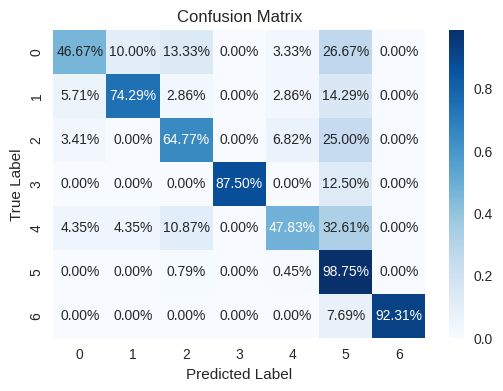

Test Sensitivity: 0.9286, Test Specificity: 0.8235


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


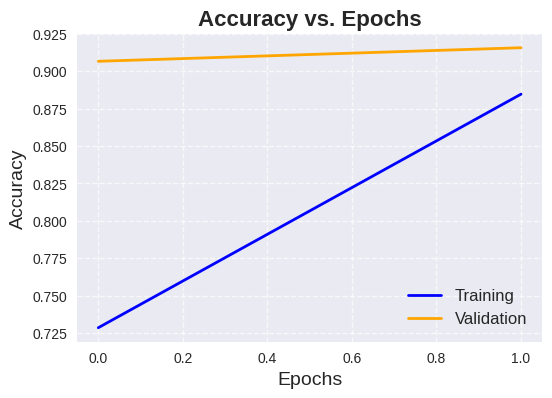

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


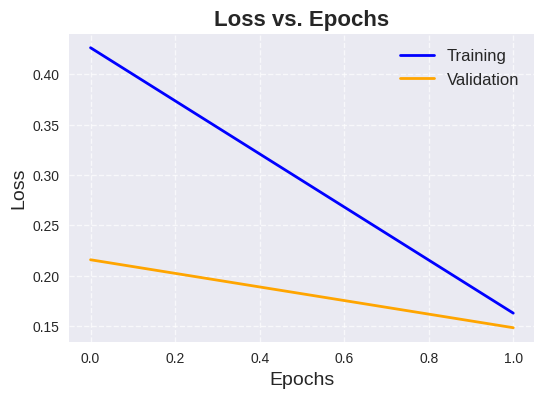

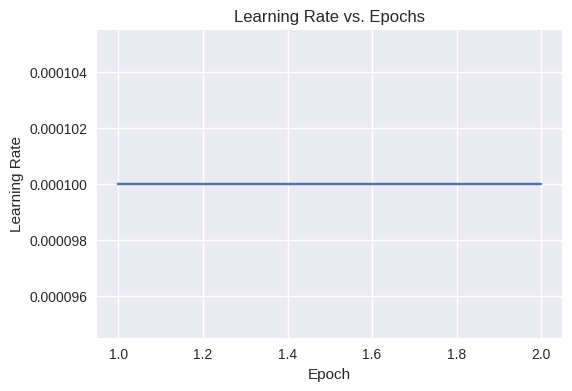

Epoch 3/120, Learning Rate: 0.0001


Epoch 3/120:   0%|          | 0/70 [00:00<?, ?it/s]

Train Loss: 0.0696, Train Accuracy: 0.9617, Train Precision: 0.9614, Train Recall: 0.9617, Train F1 Score: 0.9613


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Loss: 0.1201, Validation Accuracy: 0.8930, Validation Precision: 0.9029, Validation Recall: 0.8930, Validation F1 Score: 0.8873
Snapshot 2 saved


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Test Loss: 0.0997, Test Accuracy: 0.9157, Test Precision: 0.9077, Test Recall: 0.9157, Test F1 Score: 0.9097
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        30
           1       0.84      0.74      0.79        35
           2       0.77      0.65      0.70        88
           3       1.00      0.88      0.93         8
           4       0.65      0.48      0.55        46
           5       0.94      0.99      0.97       883
           6       1.00      0.92      0.96        13

    accuracy                           0.92      1103
   macro avg       0.84      0.73      0.78      1103
weighted avg       0.91      0.92      0.91      1103



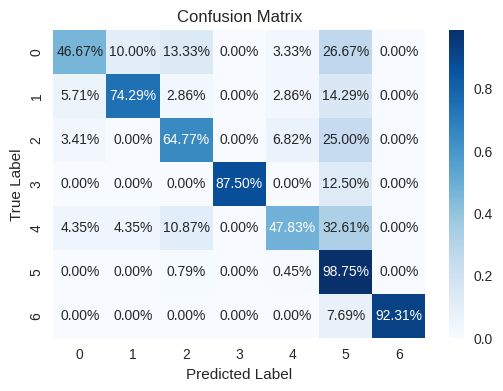

Test Sensitivity: 0.9286, Test Specificity: 0.8235


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


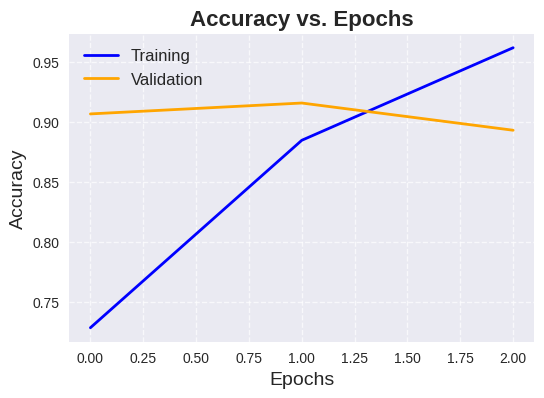

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


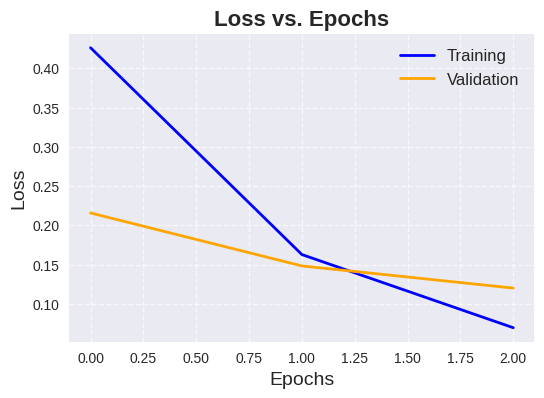

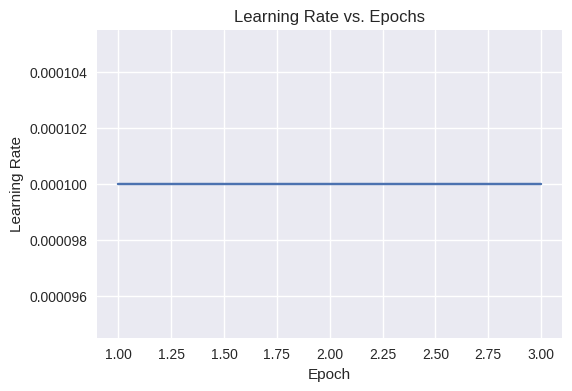

In [16]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)